In [3]:
import os
import email

def load_all_emails(path):
    new_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            with open(os.path.join(root, file), encoding='utf-8', errors='replace') as fp:
                message = email.message_from_file(fp)
                subject = ''
                for item in message.raw_items():
                    if item[0] == 'Subject':
                        subject = item[1]

                if message.is_multipart():
                    body = []
                    for b in message.get_payload():
                        body.append(str(b))
                    body = '\n'.join(body)
                else:
                    body = message.get_payload()
                
                new_list.append(subject + ' ' + body)
    return new_list

In [4]:
hamEmails = load_all_emails('datasets/SpamAssassin/easy_ham/easy_ham')
spamEmails = load_all_emails('datasets/SpamAssassin/spam_2/spam_2')

In [5]:
import pandas as pd

ham = pd.DataFrame(hamEmails, columns=["content"])
spam = pd.DataFrame(spamEmails, columns=["content"])

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

emails = np.concatenate((ham, spam))
labels = np.concatenate((np.zeros(ham.size), np.ones(spam.size)))

for train_index, test_index in split.split(emails, labels):
    emails_train, labels_train = emails[train_index], labels[train_index]
    emails_test, labels_test = emails[test_index], labels[test_index]

In [7]:
emails_train = pd.DataFrame(emails_train)
labels_train = pd.DataFrame(labels_train)
emails_test = pd.DataFrame(emails_test)
labels_test = pd.DataFrame(labels_test)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [9]:
text_clf.fit(emails_train[0], labels_train[0])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [10]:
predictions = text_clf.predict(emails_train[0])

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

def print_performance(labels, predictions):
    print(precision_score(labels, predictions))
    print(recall_score(labels, predictions))
    print(f1_score(labels, predictions))

In [12]:
print_performance(labels_train[0], predictions)

0.9945828819068255
0.8218442256042973
0.9000000000000001


In [13]:
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(emails_train[0], labels_train[0])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [14]:
predictions = text_clf.predict(emails_test[0])
print_performance(labels_test[0], predictions)

1.0
0.975
0.9873417721518987


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42)),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False)
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(emails_train[0][:1200], labels_train[0][:1200])

In [25]:
predictions = gs_clf.predict(emails_train[0])
print_performance(labels_train[0], predictions)

0.9923161361141603
0.8093106535362579
0.8915187376725838


In [26]:
gs_clf.best_params_

{'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [40]:
from sklearn.model_selection import cross_val_predict

label_train_predict = cross_val_predict(gs_clf, emails_train[0], labels_train[0], cv=3, method="decision_function")

In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_train[0], label_train_predict)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [30]:
print_performance(labels_train[0], label_train_predict)

0.9933847850055126
0.8066248880931065
0.8903162055335968


In [42]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(labels_train[0], label_train_predict)

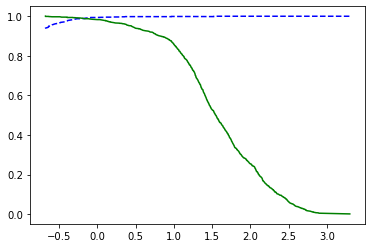

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.show()